<a href="https://colab.research.google.com/github/urieliram/tc_uc/blob/main/ExtraxtLogCPLEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,namefile_):
    fig, ax1 = plt.subplots(figsize=(6,4))
    plt.title(title_,fontsize='large',color=LETRASNARA)
    ax1.set_xlabel(xtitle_, color=LETRASNARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    plt.plot(serie_)
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [3]:
class Extract:

  def findPos(self,file,spected, starter = "Node  Left"):
    file = open(file,"r")
    for i,j in enumerate(file):
      if starter in j:
        return [(j.index(k)+len(k)-1) for k in spected]
  
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*Logfile\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp

  def createTables(self,fn):
    table_start = False
    spected = ['Node', 'Left', 'Objective', 'IInf', 'Integer', 'Bound', 'ItCnt', 'Gap']
    expectedPositions = self.findPos(fn,spected)
    tables = {"seconds":[],"ticks":[],"solution":[],"Node":[],"Left":[],"Objective":[],"IInf":[],"Integer":[],"Bound":[],"ItCnt":[],"Gap":[],"cuts":[]}
    time = None
    ticks = None
    cuts = None
    f = open(fn,"r")    
    for i in f:
      if("Cover cuts applied" in i or "Performing restart 1" in i):
        table_start = False
      if("Elapsed time" in i):
          tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          time = tmp[0]
          ticks = tmp[1]
      if(table_start):        
        if((str(i)[0] == " " or str(i)[0] == "*") and str(i)[expectedPositions[0]].isdigit()):
          i = i.replace("uts: "," uts:")
          tables["seconds"].append(time)
          tables["ticks"].append(ticks)
          tables["solution"].append(1 if i[0]=="*" else 0)
          tables["cuts"].append(None)
          for j,m in zip(expectedPositions,spected):
            if i[j] is not " ":
              tmp = ""
              for k in range(j,0,-1):
                if i[k] is not " ":
                  tmp += i[k]
                else: 
                  break 
              tmp = tmp[::-1]
              if("ut" in tmp.lower() or "infeasible" in tmp.lower() or "integral" in tmp.lower()):
                if("uts" in tmp.lower()):
                  tables["cuts"][-1] = int(tmp.split(":")[1])
                tables[m].append(tables[m][-1])
              else:
                if m == "Gap":
                  tables[m].append(float(tmp)/100)
                else: 
                  tables[m].append(float(tmp))
            else:
              tables[m].append(None)
      if("Node  Left"):
        table_start = True

    return tables

  def extract(self,fn):
    variables = {"mipPresolveEliminated":[],"mipPresolveModified":[],"aggregatorDid":[],"reducedMipHasColumns":[],"reducedMipHasNonZero":[],"reducedMipHasBinaries":[],"reducedMipHasGeneral":[],"cliqueTableMembers":[],"rootRelaxSolSeconds":[],"rootRelaxSolTicks":[]}
    variables["logFile"] = self.getFilelog(fn)
    tables = self.createTables(fn)
    f = open(fn, "r")    
    for i in f:
      if("linear optimization" in i):
        variables["linearOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("optimality gap tolerance" in i):
        variables["gapTol"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("time limit in seconds" in i):
        variables["timeLimit"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("emphasis for MIP optimization" in i):
        variables["mipOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Objective sense" in i):
        variables["objSense"] = i.replace(" ","").replace("\n","").split(":")[1]
      if("Variables" in i):
        if("Box:" in i):
          variablesValue = ["variablesValue","Nneg","Box","Binary"]
          for j,k in enumerate(re.findall(r'\d+', i.replace(" ","").replace("\n","").split(":",1)[1])):
            variables[variablesValue[j]] = float(k)
        else:
          variablesValue = ["minLB","maxUb"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
      if("Objective nonzeros" in i):
        if("Min" in i or "Max" in i):
          variablesValue = ["objNonZerosMin","objNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["objNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Linear constraints" in i):
        if("Less" in i):
          variablesValue = ["linearConstraintsValue","less","greater","equal"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          pass
      if("Nonzeros" in i):
        if("Min" in i):
          variablesValue = ["nonZerosMin","nonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["nonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("RHS nonzeros" in i):
        if("Min" in i):
          variablesValue = ["rhsNonZerosMin","rhsNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["rhsNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("CPXPARAM_TimeLimit" in i):
        variables["CPXPARAM_TimeLimit"] = float(i.replace("\n","").split(" ")[-1])
      if("MIP Presolve eliminated" in i):
        variables["mipPresolveEliminated"].append([int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)])
      if("MIP Presolve modified " in i):
        variables["mipPresolveModified"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Reduced MIP has" in i):
        if("indicators." in i):
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasBinaries"].append(tmp[0])
          variables["reducedMipHasGeneral"].append(tmp[1])
        else:
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasColumns"].append(tmp[1])
          variables["reducedMipHasNonZero"].append(tmp[-1])
          reduceHasGeneral = []
      if("Clique" in i):
        variables["cliqueTableMembers"].append(float(i.replace(" ","").replace("\n","").split(":")[1]))
      if("Aggregator did" in i):
        variables["aggregatorDid"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Root relaxation" in i):
        tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
        variables["rootRelaxSolSeconds"].append(tmp[0])
        variables["rootRelaxSolTicks"].append(tmp[1])
      if("Lift and" in i):
        variables["liftAndProjectCuts"] = int(i.replace(" ","").replace("\n","").split(":")[1])
      if("Gomory fractional" in i):
        variables["gomoryFract"] = int(i.replace(" ","").replace("\n","").split(":")[1])

    df=pd.DataFrame.from_dict(tables).rename(columns={"seconds":"seconds","ticks":"ticks","solution":"solution","Node":"node","Left":"nodesLeft","Objective":"objective","IInf":"iinf","Integer":"bestInteger","Bound":"BestBound","ItCnt":"itCnt","Gap":"gap","cuts":"cuts"})
    df['seconds'] = df['seconds'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["seconds"] + df["eps"]
    df["seconds"] = sum_column
    df['ticks'] = df['ticks'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["ticks"] + df["eps"]
    df["ticks"] = sum_column
    return df,variables

In [5]:
e = Extract()
df, dic = e.extract("/content/logfileMilparch.log")
df2, dic2 = e.extract("/content/logfileHardarch.log")
df3, dic3 = e.extract("/content/logfileSoft5arch.log")

In [6]:
def plot_results(df,df2,name='MILP',name2='HARD',maxlimitseg=0,maxlimity=0,scalex='linear',scaley='log'):
    ## https://pandas.pydata.org/pandas-docs/version/0.20.1/visualization.html

    ax1=df.plot.line( x='seconds',y='bestInteger',style='o-',label='_nolegend_')
    ax2=df.plot.line( x='seconds',y='BestBound',color= ax1.lines[-1].get_color()   ,style='o-',label=name,ax=ax1)
    ax3=df2.plot.line(x='seconds',y='bestInteger',color='blue' ,style='o-',label='_nolegend_'      ,ax=ax2)
    df2.plot.line(    x='seconds',y='BestBound'  ,color='blue' ,style='o-',label=name2,ax=ax3)
    if maxlimitseg !=0:
        plt.xlim(maxlimitseg)
    if maxlimity !=0:
        plt.ylim(maxlimity)
    plt.xscale(scalex)
    plt.yscale(scaley)

    ax4=df.plot.line(x='seconds',y='gap',style='o-',label=name)
    df2.plot.line(   x='seconds',y='gap',color='blue' ,style='o-',label=name2,ax=ax4)
    plt.xscale(scalex)
    if maxlimitseg !=0:
        plt.xlim(maxlimitseg)
    plt.ylim(0,0.1)
    plt.style.use('ggplot') ## ggplot seaborn-pastel Solarize_Light2 https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
    plt.show()

In [ ]:
plot_results(df,df2,name='MILP',name2='HARD',maxlimitseg=(0,1),maxlimity=0)

In [ ]:
plot_results(df2,df3,name='HARD',name2='SOFT5',maxlimitseg=(0,1))

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f16561c5510> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1656a63750> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f165617a3d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object 

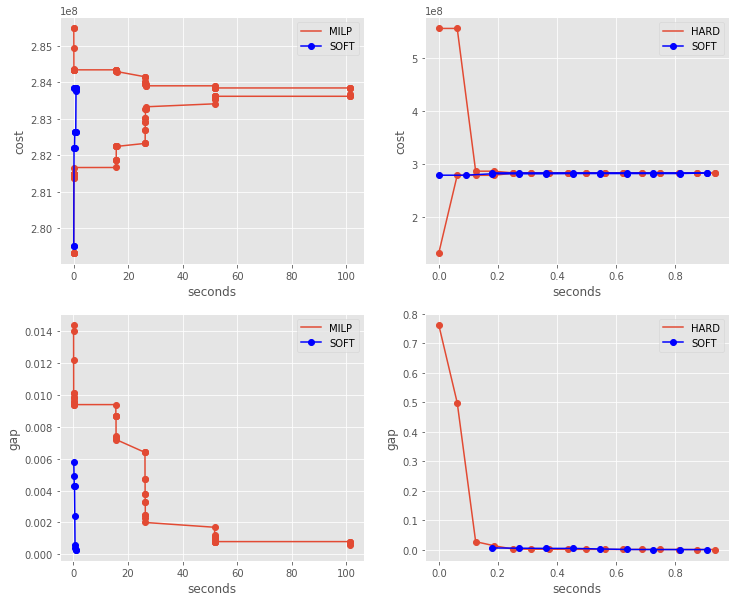

In [46]:
def plot_three_in_one(df,df2,df3,name1='MILP',name2='HARD',name3='SOFT'):
    ## https://pandas.pydata.org/pandas-docs/version/0.20.1/visualization.html
    fig, axa = plt.subplots(2, 2, figsize=(12,10))
    ## Imprime costo
    ax1=df.plot.line( x='seconds',y='bestInteger'                                 ,style='o-',label='_nolegend_',ax=axa[0,0])
    ax2=df.plot.line( x='seconds',y='BestBound'  ,color= ax1.lines[-1].get_color(),style='o-',label=name1       ,ax=ax1)
    ax3=df3.plot.line(x='seconds',y='bestInteger',color='blue'                    ,style='o-',label='_nolegend_',ax=ax2)
    df3.plot.line(    x='seconds',y='BestBound'  ,color='blue'                    ,style='o-',label=name3       ,ax=ax3)
    ## Imprime gap
    ax4=df.plot.line( x='seconds',y='gap'                                         ,style='o-',label=name1       ,ax=axa[1,0])
    df3.plot.line(    x='seconds',y='gap',color='blue' ,style='o-',label=name3,ax=ax4)  
    ax4.set(ylabel='gap') 
    ax2.set(ylabel='cost')
    ## Imprime costo
    ax5=df2.plot.line(x='seconds',y='bestInteger',style='o-',label='_nolegend_',ax=axa[0,1])
    ax6=df2.plot.line(x='seconds',y='BestBound',color= ax1.lines[-4].get_color()   ,style='o-',label=name2,ax=ax5)
    ax7=df3.plot.line(x='seconds',y='bestInteger',color='blue' ,style='o-',label='_nolegend_',ax=ax6)
    df3.plot.line(    x='seconds',y='BestBound'  ,color='blue' ,style='o-',label=name3,ax=ax7)
    ## Imprime gap
    ax8=df2.plot.line(x='seconds',y='gap',style='o-',label=name2,ax=axa[1,1])
    df3.plot.line(    x='seconds',y='gap',color='blue' ,style='o-',label=name3,ax=ax8)
    ax8.set(ylabel='gap') 
    ax5.set(ylabel='cost')

    plt.style.use('ggplot') ## ggplot seaborn-pastel Solarize_Light2 https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
    plt.show()
plot_three_in_one(df,df2,df3,name1='MILP',name2='HARD',name3='SOFT')

In [10]:
df.head()

,seconds,ticks,solution,node,nodesLeft,objective,iinf,bestInteger,BestBound,itCnt,gap,cuts,eps
0,0.000000,0.000000,0,0.0,0.0,279312000.0,95.0,NaN,279312000.0,5900.0,NaN,NaN,0.000000
1,0.017544,0.017544,0,0.0,0.0,280818000.0,181.0,NaN,279312000.0,6770.0,NaN,215.0,0.017544
2,0.035088,0.035088,0,0.0,0.0,281139000.0,175.0,NaN,279312000.0,7103.0,NaN,181.0,0.035088
3,0.052632,0.052632,0,0.0,0.0,281235000.0,219.0,NaN,279312000.0,7549.0,NaN,125.0,0.052632
4,0.070175,0.070175,0,0.0,0.0,281376000.0,194.0,NaN,279312000.0,7834.0,NaN,140.0,0.070175


In [11]:
df2.head()

,seconds,ticks,solution,node,nodesLeft,objective,iinf,bestInteger,BestBound,itCnt,gap,cuts,eps
0,0.0000,0.0000,1,0.0,0.0,NaN,NaN,556714000.0,132466000.0,2078.0,0.7621,NaN,0.0000
1,0.0625,0.0625,0,0.0,0.0,279315000.0,60.0,556714000.0,279315000.0,2078.0,0.4983,NaN,0.0625
2,0.1250,0.1250,1,0.0,0.0,NaN,NaN,287107000.0,279315000.0,2078.0,0.0271,NaN,0.1250
3,0.1875,0.1875,0,0.0,0.0,283286000.0,93.0,287107000.0,279315000.0,2646.0,0.0133,163.0,0.1875
4,0.2500,0.2500,1,0.0,0.0,NaN,NaN,283942000.0,283286000.0,2646.0,0.0023,NaN,0.2500


In [ ]:
dic

In [ ]:
import os
for filename in os.listdir("/content/"):
  if("log" in filename):
    df,dic =e.extract("/content/{}".format(filename))
    print(filename)
    print(df)